<a href="https://colab.research.google.com/github/somtirthadas/ComputerNetworks/blob/main/Final_Year_Project_Training_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Requirements download

In [3]:
# Install libs
!pip install torch torchvision transformers datasets evaluate nltk Pillow rouge_score sacremoses

  Using cached evaluate-0.4.3-py3-none-any.whl.metadata (9.2 kB)
  Using cached rouge_score-0.1.2.tar.gz (17 kB)
  Preparing metadata (setup.py) ... done
  Using cached sacremoses-0.1.1-py3-none-any.whl.metadata (8.3 kB)
  Using cached nvidia_cuda_nvrtc_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.4.127-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-9.1.0.70-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.4.5.8-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.2.1.3-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.5.147-py3-none-manylinux2014_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.6.1.9-py3-none-manylinux2014_x86_64.whl.metadata (1.6 kB)
  U

In [4]:
import os, random, torch, pandas as pd, numpy as np
from PIL import Image
from tqdm.auto import tqdm

from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

from transformers import (
    VisionEncoderDecoderModel,
    AutoConfig,
    AutoImageProcessor,
    AutoTokenizer,
)

import nltk, evaluate
nltk.download('punkt')

bleu_metric  = evaluate.load("bleu")
rouge_metric = evaluate.load("rouge")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Connecting Drive

In [1]:
# Mount Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
ROOT       = '/content/drive/MyDrive/MedVertex'
MODEL_ROOT = '/content/drive/MyDrive/DermaModel'
CSV_PATH   = os.path.join(ROOT, 'skincap_caption_filtered_base20.csv')   #Caption - Image mapping
IMG_DIR    = os.path.join(ROOT, 'skincap_images')     # Image directory
CKPT_PATH  = os.path.join(MODEL_ROOT, 'effnet_b4_biobart_14-6.pt')
CNN_CKPT_PATH = "/content/drive/MyDrive/MedVertex/cls_checkpoints_new/effnet_b4_cls74_best.pt"

#os.makedirs(CKPT_DIR, exist_ok=True)

#/content/drive/MyDrive/MedVertex/effnet_b4_biobart_3ep.pt


In [6]:
# # Tokenizer for BioBART-v2
tokenizer = AutoTokenizer.from_pretrained("GanjinZero/biobart-v2-base")

tokenizer_config.json:   0%|          | 0.00/1.13k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.59M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/892k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

In [7]:
# EfficientNet-B4 expects 380×380
image_transform = T.Compose([
    T.Resize((380, 380)),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406],
                [0.229, 0.224, 0.225]),
])


In [8]:
class SkinCAP(Dataset):
    def __init__(self, csv_file, img_dir, tokenizer, max_len=64):
        self.df        = pd.read_csv(csv_file)
        self.img_dir   = img_dir
        self.tokenizer = tokenizer
        self.max_len   = max_len

    def __len__(self):  return len(self.df)

    def __getitem__(self, idx):
        row     = self.df.iloc[idx]
        path    = os.path.join(self.img_dir, row["skincap_file_path"])
        image   = Image.open(path).convert("RGB")
        pixels  = image_transform(image)

        caption = row["caption"].lower().strip()
        enc     = self.tokenizer(
            caption,
            padding="max_length",
            truncation=True,
            max_length=self.max_len,
            return_tensors="pt"
        )

        return {
            "pixel_values": pixels,
            "input_ids":    enc.input_ids.squeeze(0),
            "attention_mask": enc.attention_mask.squeeze(0),
            "text": caption,
        }


In [9]:
# random-split 80/10/10
full_ds = SkinCAP(CSV_PATH, IMG_DIR, tokenizer, 128)
n = len(full_ds)
train_ds, val_ds, test_ds = torch.utils.data.random_split(
    full_ds, [int(0.8*n), int(0.1*n), n - int(0.8*n) - int(0.1*n)],
    generator=torch.Generator().manual_seed(42)
)

def collate(batch):
    pixel_values = torch.stack([b["pixel_values"] for b in batch])
    input_ids    = torch.stack([b["input_ids"]    for b in batch])
    attention    = torch.stack([b["attention_mask"] for b in batch])
    texts        = [b["text"] for b in batch]
    # VisionEncoderDecoderModel uses -100 to ignore label positions
    labels = input_ids.clone()
    labels[labels == tokenizer.pad_token_id] = -100
    return {"pixel_values": pixel_values,
            "labels": labels,
            "attention_mask": attention,
            "texts": texts}

train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, collate_fn=collate)
val_loader   = DataLoader(val_ds,   batch_size=2, shuffle=False, collate_fn=collate)
test_loader  = DataLoader(test_ds,  batch_size=2, shuffle=False, collate_fn=collate)

In [10]:
import torch
import torch.nn as nn
from transformers import AutoConfig, AutoModel, AutoModelForSeq2SeqLM, modeling_outputs
from pathlib import Path


"""Vision‑language model = EfficientNet‑B4 encoder (timm) -> BioBART‑v2 decoder.

Parameters
----------
enc_name : str
    HF hub id of the EfficientNet timm checkpoint (e.g. "timm/efficientnet_b4.tv_in1k").
dec_name : str
    HF hub id of the BioBART model (e.g. "GanjinZero/biobart-v2-base").
encoder_ckpt : str or Path or None, default None
    Path to your *fine‑tuned* EfficientNet `.pt` weights (the derm‑classifier). If
    provided, those weights are loaded **after** the encoder is built, while any
    mismatching keys such as the classifier head are auto‑ignored."""

class EffNetBart(nn.Module):

  def __init__(self, enc_name: str, dec_name: str, encoder_ckpt: str | Path | None = None):
      super().__init__()
      # ---------- Encoder (EfficientNet‑B4 via timm) ----------
      enc_cfg = AutoConfig.from_pretrained(enc_name)
      enc_cfg.hidden_size = 1792  # channel dim
      self.encoder = AutoModel.from_pretrained(enc_name, config=enc_cfg)

      # Optionally load fine‑tuned derm weights
      if encoder_ckpt is not None and Path(encoder_ckpt).is_file():
          state = torch.load(encoder_ckpt, map_location="cpu")
          # Drop classifier weights that don't exist in backbone‑only AutoModel
          state = {k: v for k, v in state.items() if not k.startswith("classifier")}
          missing, unexpected = self.encoder.load_state_dict(state, strict=False)
          print(f"Encoder weights loaded.  missing={len(missing)}  unexpected={len(unexpected)}")

      # ---------- Decoder (BioBART‑v2‑base) ----------
      dec_cfg = AutoConfig.from_pretrained(dec_name)
      dec_cfg.is_decoder = True
      dec_cfg.add_cross_attention = True
      self.decoder = AutoModelForSeq2SeqLM.from_pretrained(dec_name, config=dec_cfg)

      # ---------- 1×Linear bridge: 1792 → 768 ----------
      self.proj = nn.Linear(1792, 768)

  # ------------------------------------------------------------
  # Forward utilities
  # ------------------------------------------------------------
  def _encode(self, pixel_values: torch.Tensor) -> torch.Tensor:
      """Return projected visual tokens: (B, S, 768)"""
      feats = self.encoder(pixel_values, return_dict=True).last_hidden_state  # (B, C, H, W)
      feats = feats.flatten(2).transpose(1, 2).contiguous()  # → (B, S, 1792)
      return self.proj(feats)

  def forward(self, pixel_values: torch.Tensor, labels: torch.Tensor | None = None):
      enc_tokens = self._encode(pixel_values)  # (B, S, 768)
      enc_out = modeling_outputs.BaseModelOutput(last_hidden_state=enc_tokens)
      return self.decoder(
          encoder_outputs = enc_out,
          attention_mask  = torch.ones(enc_tokens.size()[:-1], device=enc_tokens.device),
          labels          = labels,
          return_dict     = True,
      )

  @torch.no_grad()
  def generate_caption(self, pixel_values: torch.Tensor, tokenizer, **gen_kw):
      self.eval()
      enc_tokens = self._encode(pixel_values.unsqueeze(0))      # (1,S,768)
      enc_out = modeling_outputs.BaseModelOutput(last_hidden_state=enc_tokens)
      ids = self.decoder.generate(
          encoder_outputs = enc_out,
          attention_mask  = torch.ones(enc_tokens.size()[:-1], device=enc_tokens.device),
          max_length      = gen_kw.get("max_length", 128),
          num_beams       = gen_kw.get("num_beams", 5),
          early_stopping  = True,
      )
      return tokenizer.decode(ids[0], skip_special_tokens=True)



In [11]:
from transformers import (
    AutoConfig, AutoModel, AutoModelForSeq2SeqLM, AutoTokenizer
)
import torch, torch.nn as nn
from torch.cuda.amp import autocast
from torch.amp import GradScaler
from torch.optim import AdamW
from transformers.modeling_outputs import BaseModelOutput
from timm import create_model


# -----------------------------MODEL INSTANCE-------------------------------------
device    = torch.device("cuda" if torch.cuda.is_available() else "cpu")
ENCODER_NAME  = "timm/tf_efficientnet_b4.in1k"
DECODER_NAME  = "GanjinZero/biobart-v2-base"

# Tokenizer for BioBART-v2
tokenizer = AutoTokenizer.from_pretrained(DECODER_NAME)

model = EffNetBart(
    enc_name    = ENCODER_NAME,
    dec_name    = DECODER_NAME,
    # encoder_ckpt= CNN_CKPT_PATH          # ← loads your derm-tuned weights
).to(device)

# model     = EffNetBart().to(device)

# freeze encoder
for p in model.encoder.parameters():
    p.requires_grad = False

encoder_params = []
decoder_params = []

for n, p in model.named_parameters():
    if 'encoder' in n:
        encoder_params.append(p)
    else:
        decoder_params.append(p)

optimizer = AdamW([
    {"params": encoder_params, "lr": 1e-5},   # smaller LR for encoder
    {"params": decoder_params, "lr": 2e-5}    # larger LR for decoder + bridge
])

# optim  = AdamW(model.parameters(), lr=2e-5)
scaler = GradScaler('cuda')


config.json:   0%|          | 0.00/580 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/77.9M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/666M [00:00<?, ?B/s]

In [12]:
print(model.named_parameters)

<bound method Module.named_parameters of EffNetBart(
  (encoder): TimmWrapperModel(
    (timm_model): EfficientNet(
      (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn1): BatchNormAct2d(
        48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (bn1): BatchNormAct2d(
              48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): SiLU(inplace=True)
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
              (act1): SiLU(inplace=True)
              (conv_expand): Conv2d(12

In [ ]:
print(model.named_modules)

<bound method Module.named_modules of EffNetBart(
  (encoder): TimmWrapperModel(
    (timm_model): EfficientNet(
      (conv_stem): Conv2dSame(3, 48, kernel_size=(3, 3), stride=(2, 2), bias=False)
      (bn1): BatchNormAct2d(
        48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
        (drop): Identity()
        (act): SiLU(inplace=True)
      )
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(48, 48, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=48, bias=False)
            (bn1): BatchNormAct2d(
              48, eps=0.001, momentum=0.1, affine=True, track_running_stats=True
              (drop): Identity()
              (act): SiLU(inplace=True)
            )
            (aa): Identity()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(48, 12, kernel_size=(1, 1), stride=(1, 1))
              (act1): SiLU(inplace=True)
              (conv_expand): Conv2d(12, 4

In [13]:
MICRO_BS  = 1      # loader batch‐size
ACC_STEPS = 4      # to simulate global BS = 4
EPOCHS    = 20
train_loss_hist = []

for epoch in range(1, EPOCHS + 1):
    model.train()
    running = 0.0
    optimizer.zero_grad()

    # Unfreeze the encoder layers after 5 epochs
    if epoch == 6:
        for n, p in model.encoder.named_parameters():
          if "blocks.4" in n or "blocks.5" in n or "blocks.6" in n:
            p.requires_grad = True
        print(f"Encoder block 4, 5, 6 unfrozen at epoch {epoch}!")

    if epoch > 5:
        print(f"Checking if encoder blocks 4, 5, 6 are unfrozen at epoch {epoch}:")
        for n, p in model.encoder.named_parameters():
            if "blocks.4" in n or "blocks.5" in n or "blocks.6" in n:
                print(f"Layer {n}: requires_grad = {p.requires_grad}")

    for step, batch in enumerate(train_loader):   # <-- you already built this loader
        with autocast():
            outs = model(
                pixel_values = batch["pixel_values"].to(device),
                labels       = batch["labels"].to(device),
            )
            loss = outs.loss / ACC_STEPS

        scaler.scale(loss).backward()

        # step every ACC_STEPS mini-batches
        if (step + 1) % ACC_STEPS == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()

        running += loss.item() * ACC_STEPS

    train_loss = running/len(train_loader)
    train_loss_hist.append(train_loss)
    print(f"Epoch {epoch}: avg loss {train_loss:.4f}")

<ipython-input-13-4229574293>:25: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1: avg loss 4.7093
Epoch 2: avg loss 1.8824
Epoch 3: avg loss 1.6662
Epoch 4: avg loss 1.5492
Epoch 5: avg loss 1.4618
Encoder block 4, 5, 6 unfrozen at epoch 6!
Checking if encoder blocks 4, 5, 6 are unfrozen at epoch 6:
Layer timm_model.blocks.4.0.conv_pw.weight: requires_grad = True
Layer timm_model.blocks.4.0.bn1.weight: requires_grad = True
Layer timm_model.blocks.4.0.bn1.bias: requires_grad = True
Layer timm_model.blocks.4.0.conv_dw.weight: requires_grad = True
Layer timm_model.blocks.4.0.bn2.weight: requires_grad = True
Layer timm_model.blocks.4.0.bn2.bias: requires_grad = True
Layer timm_model.blocks.4.0.se.conv_reduce.weight: requires_grad = True
Layer timm_model.blocks.4.0.se.conv_reduce.bias: requires_grad = True
Layer timm_model.blocks.4.0.se.conv_expand.weight: requires_grad = True
Layer timm_model.blocks.4.0.se.conv_expand.bias: requires_grad = True
Layer timm_model.blocks.4.0.conv_pwl.weight: requires_grad = True
Layer timm_model.blocks.4.0.bn3.weight: requires_gra

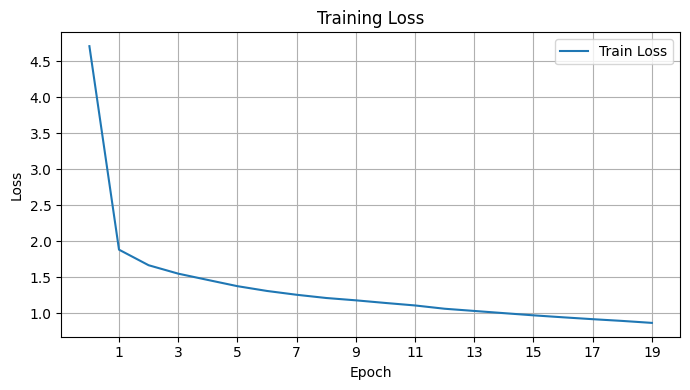

In [23]:
import matplotlib.pyplot as plt
# ───────────────── Plot loss curves ─────────────────

plt.figure(figsize=(7,4))
plt.plot(train_loss_hist, label="Train Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()
plt.grid(True)
plt.xticks(range(1, (len(train_loss_hist) + 1), 2))
plt.tight_layout()
plt.show()

In [17]:
# save model
torch.save(model.state_dict(), CKPT_PATH)
print(f"  ✔ saved new best model → {CKPT_PATH}")

  ✔ saved new best model → /content/drive/MyDrive/DermaModel/effnet_b4_biobart_14-6.pt


# Validation

BLEU Scores from the val set

In [18]:
from tqdm import tqdm
import evaluate

# Load the BLEU metric
bleu_metric = evaluate.load("bleu")

# Function to compute BLEU scores
def compute_bleu(model, tokenizer, val_loader, device, max_length=64):
    model.eval()
    preds, refs = [], []

    for batch in tqdm(val_loader, desc="Evaluating on Validation Set"):
        imgs = batch['pixel_values'].to(device)
        gts  = batch['texts']

        for img, gt in zip(imgs, gts):
            # Generate prediction
            pred = model.generate_caption(img, tokenizer, max_length=max_length)

            # Tokenize prediction and reference text for BLEU calculation
            preds.append(' '.join(pred.split()))
            refs.append([gt])  # BLEU expects list of references

    # Compute BLEU score (up to BLEU-4)
    bleu_score = bleu_metric.compute(predictions=preds, references=refs)

    print(f"BLEU-1: {bleu_score['bleu']:.4f}")
    print(f"BLEU-2: {bleu_score['precisions'][1]:.4f}")
    print(f"BLEU-3: {bleu_score['precisions'][2]:.4f}")
    print(f"BLEU-4: {bleu_score['precisions'][3]:.4f}")

    return bleu_score

# Run the evaluation to compute BLEU scores on the validation dataset
compute_bleu(model, tokenizer, val_loader, device, 128)


Evaluating on Validation Set: 100%|██████████| 153/153 [09:04<00:00,  3.56s/it]


BLEU-1: 0.0658
BLEU-2: 0.1001
BLEU-3: 0.0316
BLEU-4: 0.0162


{'bleu': 0.06582192403412684,
 'precisions': [0.3738020641356432,
  0.10005140427122763,
  0.03157295913529914,
  0.01616239357352446],
 'brevity_penalty': 0.9958618846244158,
 'length_ratio': 0.9958704230522162,
 'translation_length': 21704,
 'reference_length': 21794}

Rouge and Cider

Show Sample test

GT: in this patient, there are smooth, wholesale orange-yellow papules. skin xanthoma is suspected and further investigation is needed for confirmation.
Pred: this is a photo of a skin lesion on the left side of the face. it shows dark red patches with clear borders, central atrophy, and slight scaling, which are consistent with the clinical features of lupus erythematosus. lupus erythismatosus is a chronic autoimmune disease that typically presents with skin lesions, arthritis, fatigue, among other symptoms. treatment typically involves the use of anti-inflammatory medications and immunosuppressants.



GT: black pigmented lesions symmetrically distributed on the sides of the fingers with consistent color and regular shape, suggestive of a melanocytic nevus. melanocytic nevi are common benign skin lesions formed by the deposition of melanin in skin cells. regular monitoring is recommended, and any unusual changes or worsening symptoms should prompt timely medical evaluation for furthe

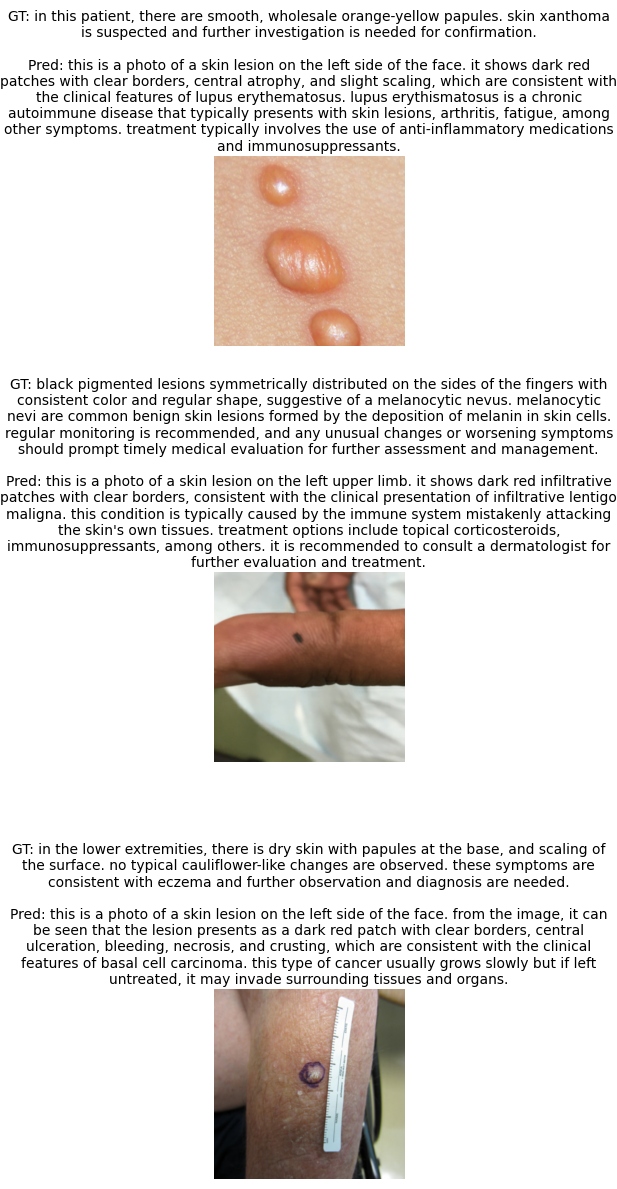

In [31]:
_img_tf = T.Compose([
    T.Resize((380, 380)),              # adjust if you used 300 or 448
    T.ToTensor(),
    T.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])

_inv_norm = lambda t: t * torch.tensor([0.229,0.224,0.225]).view(3,1,1) + \
                      torch.tensor([0.485,0.456,0.406]).view(3,1,1)


def show_test_samples(indices=None, n=4):
    """
    indices : list[int] | None. If None → random n samples.
    n       : number of samples to display if indices=None.
    """
    if indices is None:
        indices = random.sample(range(len(test_loader.dataset)), n)

    fig, axs = plt.subplots(len(indices), 1, figsize=(6,4*len(indices)))
    if len(indices)==1: axs=[axs]

    for ax, idx in zip(axs, indices):
        sample = test_loader.dataset[idx]
        img_t, gt = sample["pixel_values"], sample["text"]
        pred = model.generate_caption(img_t.to(device), tokenizer)
        print(f"GT: {gt}\nPred: {pred}\n\n\n")

        ax.imshow(_inv_norm(img_t).permute(1,2,0).clamp(0,1))
        ax.set_title(f"GT: {gt}\n\nPred: {pred}", fontsize=10, wrap=True)
        #print(f"\n\nPred: {pred}")
        ax.axis("off")
    plt.tight_layout(); plt.show()

show_test_samples(indices=[1, 2, 3])